# Deep Learning assignment

## Imports

In [36]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Use MPS on Apple Silicon if available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


----------------------

## Exploring the dataset

In [44]:
class AccentDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, max_length=16000, num_classes=5):
        self.sample_rate = sample_rate
        self.max_length  = max_length
        self.num_classes = num_classes
        self.files = []

        for root, _, fns in os.walk(data_dir):
            for fn in sorted(fns):
                if not fn.lower().endswith('.wav'):
                    continue
                label = int(fn[0]) - 1
                # keep only accents 1–5 → labels 0–4
                if 0 <= label < self.num_classes:
                    self.files.append(os.path.join(root, fn))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        waveform = waveform.mean(dim=0, keepdim=True)  # mono
        if waveform.size(1) < self.max_length:
            pad = self.max_length - waveform.size(1)
            waveform = nn.functional.pad(waveform, (0, pad))
        else:
            waveform = waveform[:, :self.max_length]
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-5)
        label = int(os.path.basename(path)[0]) - 1
        return waveform.to(device), torch.tensor(label, dtype=torch.long, device=device)


In [45]:
train_dir = 'Train'        
test_dir  = 'Test set'     

train_ds     = AccentDataset(train_dir,  num_classes=5)
test_ds      = AccentDataset(test_dir,   num_classes=5)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32)

In [46]:
import os
import torchaudio
import numpy as np
from collections import Counter


durations = []
accents   = []
genders   = []

for path in train_ds.files:
    info = torchaudio.info(path)
    dur = info.num_frames / info.sample_rate
    durations.append(dur)
    fn = os.path.basename(path)
    accents.append(int(fn[0]))
    genders.append(fn[1])

# 2) Print stats
print(f"Total train files: {len(durations)}")
print(f"Duration (s): min={min(durations):.2f}, max={max(durations):.2f}, "
      f"mean={np.mean(durations):.2f}, median={np.median(durations):.2f}")

print("Accent distribution:", Counter(accents))
print("Gender distribution:", Counter(genders))


Total train files: 3166
Duration (s): min=1.67, max=12.97, mean=5.26, median=5.04
Accent distribution: Counter({4: 754, 1: 740, 2: 626, 3: 564, 5: 482})
Gender distribution: Counter({'f': 1639, 'm': 1527})


Axes(0.125,0.11;0.775x0.77)
gender    f    m
accent          
1       520  220
2       287  339
3       242  322
4       357  397
5       233  249


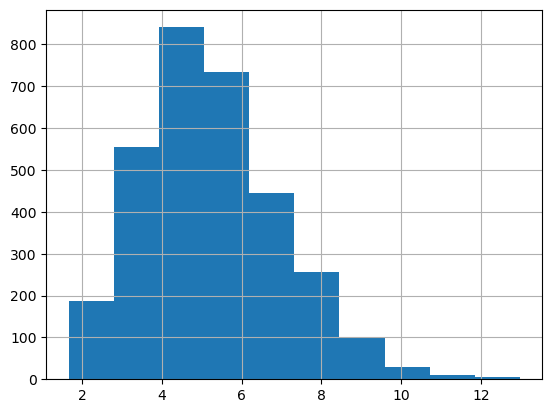

In [47]:
import pandas as pd

df = pd.DataFrame({
    "duration": durations,
    "accent":   accents,
    "gender":   genders,
})


print(df.duration.hist(bins=10))


print(df.groupby(["accent","gender"]).size().unstack(fill_value=0))


-----

## Dataset import/definitions

In [37]:
class AccentDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, max_length=16000, num_classes=5):
        self.sample_rate = sample_rate
        self.max_length  = max_length
        self.num_classes = num_classes
        self.files = []

        for root, _, fns in os.walk(data_dir):
            for fn in sorted(fns):
                if not fn.lower().endswith('.wav'):
                    continue
                label = int(fn[0]) - 1
                # keep only accents 1–5 → labels 0–4
                if 0 <= label < self.num_classes:
                    self.files.append(os.path.join(root, fn))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        waveform = waveform.mean(dim=0, keepdim=True)  # mono
        if waveform.size(1) < self.max_length:
            pad = self.max_length - waveform.size(1)
            waveform = nn.functional.pad(waveform, (0, pad))
        else:
            waveform = waveform[:, :self.max_length]
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-5)
        label = int(os.path.basename(path)[0]) - 1
        return waveform.to(device), torch.tensor(label, dtype=torch.long, device=device)


------

## Dataloaders

The dataloaders are used for...

In [38]:
train_dir = 'Train'        
test_dir  = 'Test set'     

train_ds     = AccentDataset(train_dir,  num_classes=5)
test_ds      = AccentDataset(test_dir,   num_classes=5)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32)


---------

## Model - CNN (task 1.2a)

In [54]:
# class RawCNN(nn.Module):
#     def __init__(self, num_classes=5, max_length=16000):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv1d(1, 16, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(2),
#             nn.Conv1d(16, 32, kernel_size=5, padding=2),
#             nn.ReLU(),
#             nn.MaxPool1d(2),
#         )
#         reduced = max_length // 4  # two poolings of 2
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(32 * reduced, 128),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, num_classes),
#         )

#     def forward(self, x):
#         return self.fc(self.conv(x))

# model = RawCNN(num_classes=5, max_length=train_ds.max_length).to(device)

class RawCNNVarLen10(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.MaxPool1d(2),
        )
        # keep 10 time‐steps per channel
        self.global_pool = nn.AdaptiveAvgPool1d(10)  
        self.classifier = nn.Sequential(
            nn.Flatten(),                      # [batch, 64*10 = 640]
            nn.Linear(64*10, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.global_pool(x)
        return self.classifier(x)



model = RawCNNVarLen10(num_classes=5).to(device)

# Loss and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [55]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = correct = total = 0
    with torch.set_grad_enabled(train):
        for X, y in loader:
            logits = model(X)
            loss   = criterion(logits, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total   += X.size(0)
    return total_loss/total, correct/total


### Training loop

In [56]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    tl, ta = run_epoch(train_loader, train=True)
    sl, sa = run_epoch(test_loader,  train=False)  
    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {tl:.4f}, Acc: {ta:.4f} | "
          f"Test  Loss: {sl:.4f}, Acc: {sa:.4f}")



Epoch 01 | Train Loss: 1.6039, Acc: 0.2498 | Test  Loss: 1.6442, Acc: 0.2114
Epoch 02 | Train Loss: 1.5569, Acc: 0.2884 | Test  Loss: 1.7048, Acc: 0.2215
Epoch 03 | Train Loss: 1.5360, Acc: 0.2824 | Test  Loss: 1.6881, Acc: 0.1711
Epoch 04 | Train Loss: 1.5256, Acc: 0.3057 | Test  Loss: 1.7248, Acc: 0.2047
Epoch 05 | Train Loss: 1.5125, Acc: 0.2982 | Test  Loss: 1.7454, Acc: 0.1913
Epoch 06 | Train Loss: 1.4968, Acc: 0.3181 | Test  Loss: 1.8133, Acc: 0.1846
Epoch 07 | Train Loss: 1.4859, Acc: 0.3222 | Test  Loss: 1.8212, Acc: 0.1812
Epoch 08 | Train Loss: 1.4782, Acc: 0.3225 | Test  Loss: 1.8326, Acc: 0.1946
Epoch 09 | Train Loss: 1.4830, Acc: 0.3272 | Test  Loss: 1.7899, Acc: 0.1745
Epoch 10 | Train Loss: 1.4639, Acc: 0.3335 | Test  Loss: 1.8084, Acc: 0.2013


-------------------

In [43]:
import torch
print("Train labels:", torch.bincount(torch.tensor([y for _,y in train_ds])))
print("Test  labels:", torch.bincount(torch.tensor([y for _,y in test_ds])))



Train labels: tensor([740, 626, 564, 754, 482])
Test  labels: tensor([54, 58, 65, 62, 59])
